In [1]:
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.optim as optim
import numpy as np
import h5py
import os
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.current_device())  # Should print the device index (e.g., 0)
print(torch.cuda.get_device_name(0))  # S

True
0
NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
class GanglionCellDataset(Dataset):
    def __init__(self, h5_file):
        
        self.h5_file = h5_file
        with h5py.File(h5_file, 'r') as f:
            self.stimuli = np.array(f['train/stimulus'])  # (359802, 50, 50)
            self.responses = np.array(f['train/response/firing_rate_10ms'])  # (9, 359802)

        # Reshape stimuli to (N, 1, H, W) for CNN
        self.stimuli = self.stimuli[:, np.newaxis, :, :].astype(np.float32)  # (359802, 1, 50, 50)

        # Transpose responses to match sample dimension
        self.responses = self.responses.T.astype(np.float32)  # (359802, 9)

    def __len__(self):
        return len(self.stimuli)

    def __getitem__(self, idx):
        stimuli = torch.tensor(self.stimuli[idx], device=DEVICE)  # Move to device
        responses = torch.tensor(self.responses[idx], device=DEVICE)  # Move to device
        return stimuli, responses

In [4]:
class GaussianNoise(nn.Module):
    def __init__(self, std: float):
        super(GaussianNoise, self).__init__()
        self.std = std

    def forward(self, x):
        if self.training:  # Only apply noise during training
            noise = torch.randn_like(x).to(x.device) * self.std  # Ensure noise is on the same device
            return x + noise
        return x

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)  # Flatten the input tensor

class Exponential(nn.Module):
    def __init__(self, train_off=False):
        super(Exponential, self).__init__()
        self.train_off = train_off

    def forward(self, x):
        if self.train_off:
            return torch.exp(x)  # Example: Exponential activation without training
        else:
            return torch.exp(x)  # Modify as needed based on the desired behavior

In [5]:
class TDRModel(nn.Module):
    """
    Base class for most models. Handles setting most of the member
    variables that are shared for most model definitions.
    """
    def __init__(self, n_units=5, noise=.05, bias=True, gc_bias=None,
                 chans=[8,8], bn_moment=.01, softplus=True,
                 inference_exp=False, img_shape=(40,50,50),
                 ksizes=(15,11,11), recurrent=False, kinetic=False,
                 convgc=False, centers=None, bnorm_d=1,
                 activ_fxn='ReLU', **kwargs):
        """
        Initializes common parameters for retinal models.
        """
        super().__init__()
        self.n_units = n_units
        self.chans = chans
        self.softplus = softplus
        self.infr_exp = inference_exp
        self.bias = bias
        self.img_shape = img_shape
        self.ksizes = ksizes
        self.gc_bias = gc_bias
        self.noise = noise
        self.bn_moment = bn_moment
        self.recurrent = recurrent
        self.kinetic = kinetic
        self.convgc = convgc
        self.centers = centers
        self.bnorm_d = bnorm_d
        assert bnorm_d in [1, 2], "Only 1D and 2D batchnorm are supported."
        self.activ_fxn = activ_fxn

    def forward(self, x):
        """
        This function should be implemented in child classes.
        """
        raise NotImplementedError("Forward function must be implemented in child class.")

    def update_shape(self, shape, kernel_size):
        """
        Helper function to update spatial dimensions after convolution.

        Parameters:
        - shape: tuple (height, width)
        - kernel_size: int or tuple

        Returns:
        - New shape after convolution
        """
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        h_out = shape[0] - kernel_size[0] + 1
        w_out = shape[1] - kernel_size[1] + 1
        return (h_out, w_out)

    def extra_repr(self):
        """
        This function is used in model printing. Shows model parameters.
        """
        s = ['n_units={}', 'noise={}', 'bias={}', 'gc_bias={}',
             'chans={}', 'bn_moment={}', 'softplus={}',
             'inference_exp={}', 'img_shape={}', 'ksizes={}']
        return ", ".join(s).format(self.n_units, self.noise, self.bias,
                                   self.gc_bias, self.chans,
                                   self.bn_moment, self.softplus,
                                   self.infr_exp, self.img_shape, self.ksizes)

    def requires_grad(self, state: bool):
        """
        Enables or disables gradient calculations.

        Parameters:
        - state (bool): True to enable gradients, False to disable.
        """
        for p in self.parameters():
            p.requires_grad = state

In [6]:
# Exact BNCNN Model
class BNCNN(TDRModel):
    """
    BatchNorm CNN for predicting ganglion cell responses.
    """

    def __init__(self, gauss_prior=0, **kwargs):
        super().__init__(**kwargs)
        self.name = 'McNiruNet'
        self.gauss_prior = gauss_prior
        modules = []
        self.shapes = []
        shape = self.img_shape[1:]

        modules.append(nn.Conv2d(self.img_shape[0], self.chans[0], kernel_size=self.ksizes[0], bias=self.bias))
        shape = self.update_shape(shape, self.ksizes[0])
        self.shapes.append(tuple(shape))

        if self.bnorm_d == 1:
            modules.append(Flatten())
            size = self.chans[0] * shape[0] * shape[1]
            modules.append(nn.BatchNorm1d(size, eps=1e-3, momentum=self.bn_moment))
            modules.append(Reshape((-1, self.chans[0], *shape)))
        else:
            modules.append(nn.BatchNorm2d(self.chans[0], eps=1e-3, momentum=self.bn_moment))

        modules.append(GaussianNoise(std=self.noise))
        modules.append(getattr(nn, self.activ_fxn)())

        modules.append(nn.Conv2d(self.chans[0], self.chans[1], kernel_size=self.ksizes[1], bias=self.bias))
        shape = self.update_shape(shape, self.ksizes[1])
        self.shapes.append(tuple(shape))

        if self.bnorm_d == 1:
            modules.append(Flatten())
            size = self.chans[1] * shape[0] * shape[1]
            modules.append(nn.BatchNorm1d(size, eps=1e-3, momentum=self.bn_moment))
            modules.append(Reshape((-1, self.chans[1], shape[0], shape[1])))
        else:
            modules.append(nn.BatchNorm2d(self.chans[1], eps=1e-3, momentum=self.bn_moment))

        modules.append(GaussianNoise(std=self.noise))
        modules.append(getattr(nn, self.activ_fxn)())

        if self.convgc:
            modules.append(nn.Conv2d(self.chans[1], self.n_units, kernel_size=self.ksizes[2], bias=self.gc_bias))
            shape = self.update_shape(shape, self.ksizes[2])
            self.shapes.append(tuple(shape))
            modules.append(GrabUnits(self.centers, self.ksizes, self.img_shape))
        else:
            modules.append(Flatten())
            size = self.chans[1] * shape[0] * shape[1]
            modules.append(nn.Linear(size, self.n_units, bias=self.gc_bias))

        modules.append(nn.BatchNorm1d(self.n_units, eps=1e-3, momentum=self.bn_moment))

        if self.softplus:
            modules.append(nn.Softplus())
        else:
            modules.append(Exponential(train_off=True))

        self.sequential = nn.Sequential(*modules)

        if self.gauss_prior > 0:
            for i, seq_idx in enumerate([0, 6]):
                weight = self.sequential[seq_idx].weight
                filters = []
                for out_i in range(weight.shape[0]):
                    kernels = []
                    for in_i in range(weight.shape[1]):
                        prior_x = signal.gaussian(weight.shape[-1], std=self.gauss_prior)
                        prior_y = signal.gaussian(weight.shape[-2], std=self.gauss_prior)
                        prior = np.outer(prior_y, prior_x)
                        kernels.append(prior)
                    filters.append(np.asarray(kernels))
                prior = np.asarray(filters)
                denom = np.sqrt(weight.shape[0] + weight.shape[1])
                prior = prior / np.max(prior) / denom
                prior = torch.FloatTensor(prior)
                self.sequential[seq_idx].weight.data = prior

    def forward(self, x):
        if not self.training and self.infr_exp:
            return torch.exp(self.sequential(x))
        return self.sequential(x)

In [7]:
def train_model(h5_file, hyperparams, batch_size=32, lr=0.001, epochs=15):
    dataset = GanglionCellDataset(h5_file)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = BNCNN(**hyperparams).to(DEVICE)  # Ensure model is on the GPU
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    writer = SummaryWriter(log_dir="runs/bncnn_experiment")  # Create a TensorBoard logger

    loss_history = []
    accuracy_history = []
    all_predictions = []
    all_targets = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0
        count = 0

        for stimuli, firing_rate in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            stimuli, firing_rate = stimuli.to(DEVICE), firing_rate.to(DEVICE)

            optimizer.zero_grad()
            predictions = model(stimuli)
            loss = loss_fn(predictions, firing_rate)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            # Calculate correlation as a proxy for accuracy
            try:
                pred_np = predictions.detach().cpu().numpy()
                target_np = firing_rate.detach().cpu().numpy()

                if np.std(pred_np) > 0 and np.std(target_np) > 0:
                    correlation = np.corrcoef(pred_np.flatten(), target_np.flatten())[0, 1]
                else:
                    correlation = 0
                running_accuracy += correlation
                count += 1

                if len(all_predictions) < 10000:  # Limit to 10,000 samples
                    all_predictions.extend(pred_np.flatten())
                    all_targets.extend(target_np.flatten())

            except Exception as e:
                print(f"Error in correlation calculation: {e}")


            # Store predictions and actual values for final visualization
            all_predictions.extend(pred_np.flatten())
            all_targets.extend(target_np.flatten())

        avg_loss = running_loss / len(dataloader)
        avg_accuracy = running_accuracy / count if count > 0 else 0 # Mean correlation across batches
        loss_history.append(avg_loss)
        accuracy_history.append(avg_accuracy)

        writer.add_scalar("Loss/train", avg_loss, epoch)
        writer.add_scalar("Accuracy/train", avg_accuracy, epoch)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}, Accuracy: {avg_accuracy:.4f}")

    # Save Model
    save_path = "bncnn_model.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

    # Plot Loss Curve
    plt.figure(figsize=(10, 4))
    plt.plot(range(1, epochs + 1), loss_history, marker='o', linestyle='-', color='b', label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Accuracy Curve
    plt.figure(figsize=(10, 4))
    plt.plot(range(1, epochs + 1), accuracy_history, marker='s', linestyle='-', color='g', label='Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Pearson Correlation')
    plt.title('Training Accuracy Curve')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Predicted vs Real Values
    plt.figure(figsize=(6, 6))
    plt.scatter(all_targets, all_predictions, alpha=0.5, color='r')
    plt.plot([-1, 1], [-1, 1], linestyle='--', color='black')  # Reference line (y=x)
    plt.xlabel('Actual Firing Rate')
    plt.ylabel('Predicted Firing Rate')
    plt.title('Predicted vs Real Values')
    plt.grid()
    plt.show()



Epoch 1/15: 100%|██████████| 11244/11244 [05:53<00:00, 31.80it/s]


Epoch 1/15, Loss: 101.497236, Accuracy: 0.1662


Epoch 2/15: 100%|██████████| 11244/11244 [08:20<00:00, 22.48it/s] 


Epoch 2/15, Loss: 99.384704, Accuracy: 0.2160


Epoch 3/15: 100%|██████████| 11244/11244 [06:28<00:00, 28.98it/s] 


Epoch 3/15, Loss: 97.096073, Accuracy: 0.2596


Epoch 4/15: 100%|██████████| 11244/11244 [05:52<00:00, 31.86it/s]


Epoch 4/15, Loss: 94.591053, Accuracy: 0.3005


Epoch 5/15: 100%|██████████| 11244/11244 [04:13<00:00, 44.40it/s]


Epoch 5/15, Loss: 92.681827, Accuracy: 0.3287


Epoch 6/15: 100%|██████████| 11244/11244 [03:33<00:00, 52.73it/s]


Epoch 6/15, Loss: 91.158941, Accuracy: 0.3496


Epoch 7/15: 100%|██████████| 11244/11244 [04:45<00:00, 39.39it/s]


Epoch 7/15, Loss: 89.922463, Accuracy: 0.3661


Epoch 8/15: 100%|██████████| 11244/11244 [04:17<00:00, 43.63it/s]


Epoch 8/15, Loss: 89.004154, Accuracy: 0.3773


Epoch 9/15: 100%|██████████| 11244/11244 [03:59<00:00, 46.89it/s]


Epoch 9/15, Loss: 88.180818, Accuracy: 0.3878


Epoch 10/15: 100%|██████████| 11244/11244 [03:46<00:00, 49.58it/s]


Epoch 10/15, Loss: 87.419921, Accuracy: 0.3974


Epoch 11/15: 100%|██████████| 11244/11244 [04:00<00:00, 46.70it/s]


Epoch 11/15, Loss: 86.833042, Accuracy: 0.4049


Epoch 12/15: 100%|██████████| 11244/11244 [03:57<00:00, 47.29it/s]


Epoch 12/15, Loss: 86.154543, Accuracy: 0.4131


Epoch 13/15: 100%|██████████| 11244/11244 [04:02<00:00, 46.39it/s]


Epoch 13/15, Loss: 85.646959, Accuracy: 0.4192


Epoch 14/15: 100%|██████████| 11244/11244 [04:15<00:00, 43.97it/s]


Epoch 14/15, Loss: 85.087292, Accuracy: 0.4261


Epoch 15/15: 100%|██████████| 11244/11244 [03:47<00:00, 49.52it/s]


Epoch 15/15, Loss: 84.777379, Accuracy: 0.4288
Model saved to bncnn_model.pth


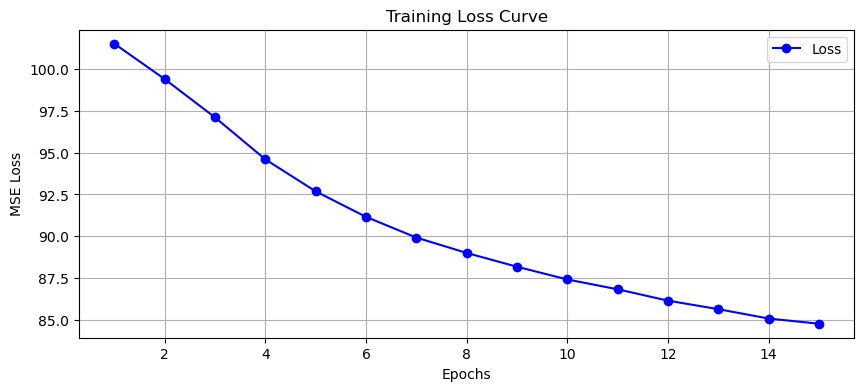

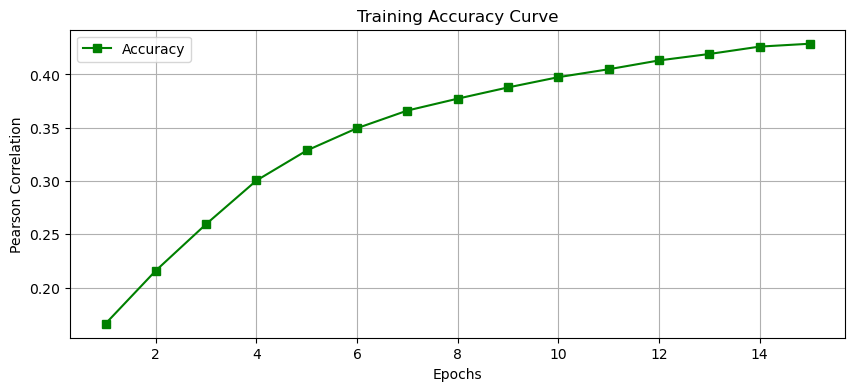

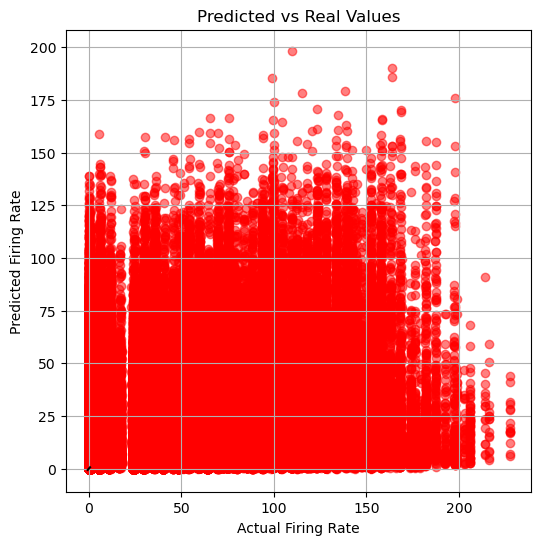

In [8]:
# Define Hyperparameters
hyperparams = {
    'img_shape': (1, 50, 50),
    'chans': [32, 64],
    'ksizes': [5, 5, 3],
    'bias': False,
    'bnorm_d': 2,
    'bn_moment': 0.1,
    'noise': 0.1,
    'activ_fxn': 'ReLU',
    'n_units': 9,
    'gc_bias': False,
    'softplus': False,
    'convgc': False,
    'centers': None
}

h5_path = r'C:\Users\krmri\Downloads\neural_code_data\neural_code_data\ganglion_cell_data\15-10-07\naturalscene.h5'
train_model(h5_path, hyperparams)